In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.xception import Xception
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 299
BATCH_SIZE = 16

In [3]:
artifact_path = Path("../../artifacts/xception")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

20


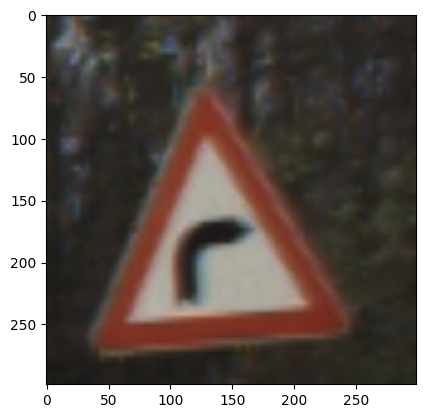

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = Xception(output_size=num_class).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
Xception                                                --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─ReLU: 3-3                                   --
│    └─Conv2dNormActivation: 2-2                        --
│    │    └─Conv2d: 3-4                                 18,432
│    │    └─BatchNorm2d: 3-5                            128
│    │    └─ReLU: 3-6                                   --
│    └─ResBlock: 2-3                                    --
│    │    └─Sequential: 3-7                             27,200
│    │    └─Sequential: 3-8                             8,448
│    └─ResBlock: 2-4                                    --
│    │    └─Sequential: 3-9                             103,552
│    │    └─Sequential: 3-10     

# training

In [13]:
epochs = 10
acc_iters = 32 // BATCH_SIZE

In [14]:
trainer = ClassificationTrainer(epochs, device, acc_iters)
trainer.recorder.increment_data_size(len(train_dataset))

In [15]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [16]:
training_loss = trainer.run(train_loader, model, optim, criterion)

Enable AMP: False
Training...


100%|██████████| 1665/1665 [05:25<00:00,  5.12it/s]


------------------------------------
Epoch 1
------------------------------------
total: 3.0437e-02 (0.00%)


100%|██████████| 1665/1665 [07:01<00:00,  3.95it/s]


------------------------------------
Epoch 2
------------------------------------
total: 3.3291e-03 (-89.00%)


100%|██████████| 1665/1665 [06:31<00:00,  4.25it/s]


------------------------------------
Epoch 3
------------------------------------
total: 1.8146e-03 (-45.00%)


100%|██████████| 1665/1665 [06:59<00:00,  3.97it/s]


------------------------------------
Epoch 4
------------------------------------
total: 1.8497e-03 (2.00%)


100%|██████████| 1665/1665 [06:16<00:00,  4.43it/s]


------------------------------------
Epoch 5
------------------------------------
total: 1.4245e-03 (-23.00%)


100%|██████████| 1665/1665 [05:06<00:00,  5.43it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.0429e-03 (-27.00%)


100%|██████████| 1665/1665 [05:17<00:00,  5.24it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.2429e-03 (19.00%)


100%|██████████| 1665/1665 [05:08<00:00,  5.39it/s]


------------------------------------
Epoch 8
------------------------------------
total: 1.2434e-03 (0.00%)


100%|██████████| 1665/1665 [05:06<00:00,  5.43it/s]


------------------------------------
Epoch 9
------------------------------------
total: 6.4743e-04 (-48.00%)


100%|██████████| 1665/1665 [05:08<00:00,  5.40it/s]

------------------------------------
Epoch 10
------------------------------------
total: 8.6002e-04 (33.00%)


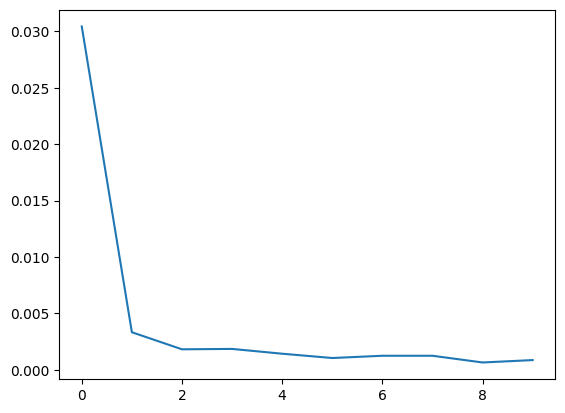

In [17]:
plt.plot(training_loss)

# inference

In [18]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [19]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [21]:
evaluator = ClassificationEvaluator(num_class, device)

In [22]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 790/790 [01:01<00:00, 12.80it/s]


In [23]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 1.0
1         : 0.9847222222222223
2         : 0.9853333333333333
3         : 0.9711111111111111
4         : 0.990909090909091
5         : 0.9984126984126984
6         : 0.7666666666666667
7         : 0.9955555555555555
8         : 0.9177777777777778
9         : 1.0
10        : 0.9878787878787879
11        : 1.0
12        : 1.0
13        : 0.9916666666666667
14        : 1.0
15        : 0.9666666666666667
16        : 0.96
17        : 0.9583333333333334
18        : 0.9794871794871794
19        : 0.7166666666666667
20        : 0.9666666666666667
21        : 0.8777777777777778
22        : 0.8583333333333333
23        : 0.9533333333333334
24        : 0.9555555555555556
25        : 0.9875
26        : 0.9722222222222222
27        : 0.4666666666666667
28        : 0.9933333333333333
29        : 1.0
30        : 0.8933333333333333
31        : 0.9814814814814815
32        : 0.9166666666666666
33        : 0.7761904761904762
34        : 0.9833333333333333
35        : 0.9384615384615385
3

In [24]:
per_class_acc.mean()

np.float64(0.9102379507172228)

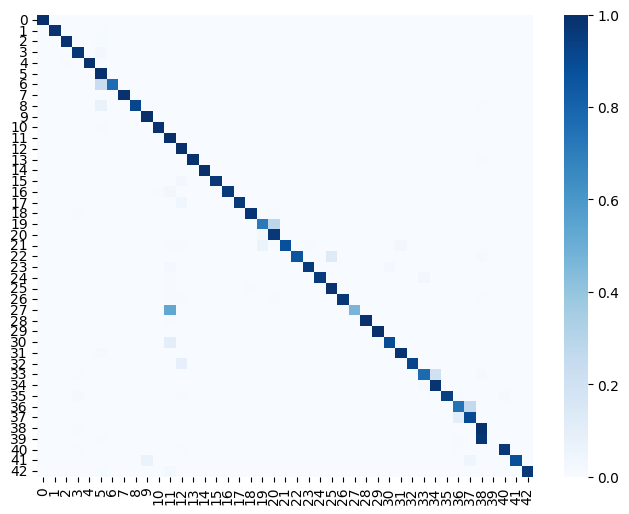

In [25]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [26]:
model_path = artifact_path / f'xception.pth'

In [27]:
torch.save(model.state_dict(), model_path)

In [28]:
get_file_size(model_path)

'80.42MiB'

In [29]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>